<a href="https://colab.research.google.com/github/aahhiiinn/ahin/blob/main/SRGAN_upscaling_and_colorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
#!tar -xvf /content/VOCtrainval_11-May-2012.tar

In [ ]:
!gdown https://drive.google.com/uc?id=1xgk7svdjBiEyzyUVoZrCz4PP6dSjVL8S

Downloading...
From: https://drive.google.com/uc?id=1xgk7svdjBiEyzyUVoZrCz4PP6dSjVL8S
To: /content/pascal_20_detection.zip
100% 1.93G/1.93G [00:23<00:00, 84.0MB/s]


In [ ]:

#!wget http://images.cocodataset.org/zips/val2017.zip

In [ ]:
!unzip --qq pascal_20_detection.zip

In [ ]:
#!unzip -qq /content/val2017.zip

In [ ]:
'''
from google.colab import drive
drive.mount('/content/drive')
'''

"\nfrom google.colab import drive\ndrive.mount('/content/drive')\n"

##Library

In [ ]:
from sklearn.model_selection import train_test_split

import os
from os import listdir
from os.path import join
import shutil
import random
import matplotlib.pyplot as plt
import math
from math import log10
import time

from PIL import Image
import torch
from torch import nn
import torch.optim as optim
from torchvision.models.vgg import vgg16
from torch.utils.data.dataset import Dataset
from torch.utils.data import random_split, DataLoader
from torchvision.transforms import Compose, RandomCrop, ToTensor, ToPILImage, CenterCrop, Resize, Grayscale

import cv2
from tqdm import tqdm

## Parameter

In [ ]:
#crop_size는 4의 배수여야 함.
#crop_size 보다 큰 사이즈의 이미지가 있는지 확인해줘야 함.
crop_size = 68#96#68 #96

upscale_factor = 4
epochs = 250
batch_size = 64

dataset_dir = '/content/pascal_20_detection/imgs'

save_path = '/content'


## 데이터 설정

In [ ]:
# 데이터셋 디렉토리에서 파일 목록 가져오기
all_files = [f for f in os.listdir(dataset_dir) if f.endswith('.jpg')]

#crop size 보다 큰거
valid_files = [file for file in all_files if file not in ['2008_001823.jpg', '2008_003374.jpg']]

# 데이터셋을 training set과 validation set으로 나누기
train_files, temp_files = train_test_split(valid_files, test_size=0.2, random_state=42)
val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)


# 각 세트의 개수 출력
print("Training set: {}개, Validation set: {}개, Test set: {}개".format(len(train_files), len(val_files), len(test_files)))

# 각 세트의 파일을 저장할 디렉토리 생성
train_save_dir = os.path.join(save_path, 'train_dataset')
val_save_dir = os.path.join(save_path, 'val_dataset')
test_save_dir = os.path.join(save_path, 'test_dataset')

# 디렉토리가 존재하지 않으면 생성
os.makedirs(train_save_dir, exist_ok=True)
os.makedirs(val_save_dir, exist_ok=True)
os.makedirs(test_save_dir, exist_ok=True)

min_image_size = crop_size  # 예시로 96으로 설정, 실제로 필요한 크기로 수정


# 훈련 세트 파일 복사
for file in train_files:
    src_path = os.path.join(dataset_dir, file)


    dest_path = os.path.join(train_save_dir, file)
    shutil.copy(src_path, dest_path)

# 검증 세트 파일 복사
for file in val_files:
    src_path = os.path.join(dataset_dir, file)


    dest_path = os.path.join(val_save_dir, file)
    shutil.copy(src_path, dest_path)

# 테스트 세트 파일 복사
for file in test_files:
    src_path = os.path.join(dataset_dir, file)

    dest_path = os.path.join(test_save_dir, file)
    shutil.copy(src_path, dest_path)




Training set: 13618개, Validation set: 1702개, Test set: 1703개


##Dataset

In [ ]:
def is_image_file(filename):
    return any(filename.endswith(extension) for extension in ['.png', '.jpg', '.jpeg', '.PNG', '.JPG', '.JPEG'])

def train_hr_transform(crop_size):
    return Compose([
        RandomCrop(crop_size),
        ToTensor()
    ])

def train_lr_transform(crop_size, upscale_factor):
    return Compose([
        ToPILImage(),
        Resize(crop_size // upscale_factor, interpolation=Image.BICUBIC),
        ToTensor(),
        Grayscale(num_output_channels = 3)
    ])


In [ ]:
class TrainDataset(Dataset):
    def __init__(self, dataset_dir, crop_size, upscale_factor):
        super(TrainDataset, self).__init__()
        self.image_filenames = [join(dataset_dir, x) for x in listdir(dataset_dir) if is_image_file(x)]
        #crop_size = calculate_valid_crop_size(crop_size, upscale_factor)
        self.hr_transform = train_hr_transform(crop_size)
        self.lr_transform = train_lr_transform(crop_size, upscale_factor)

    def __getitem__(self, index):
        hr_image = self.hr_transform(Image.open(self.image_filenames[index]))
        hr_gray_image = self.hr_transform(Image.open(self.image_filenames[index]).convert('L'))
        lr_image = self.lr_transform(hr_image)
        return lr_image, hr_image

    def __len__(self):
        return len(self.image_filenames)


class ValDataset(Dataset):
    def __init__(self, dataset_dir, crop_size,upscale_factor):
        super(ValDataset, self).__init__()
        self.upscale_factor = upscale_factor
        self.image_filenames = [join(dataset_dir, x) for x in listdir(dataset_dir) if is_image_file(x)]

    def __getitem__(self, index):
        hr_image = Image.open(self.image_filenames[index])
        #w, h = hr_image.size
        #crop_size = calculate_valid_crop_size(min(w, h), self.upscale_factor)
        lr_scale = Resize(crop_size // self.upscale_factor, interpolation=Image.BICUBIC)
        hr_scale = Resize(crop_size, interpolation=Image.BICUBIC)
        hr_image = CenterCrop(crop_size)(hr_image)
        lr_image = lr_scale(hr_image)
        hr_restore_img = hr_scale(lr_image)
        return ToTensor()(lr_image), ToTensor()(hr_restore_img), ToTensor()(hr_image)

    def __len__(self):
        return len(self.image_filenames)


class TestDataset(Dataset):
    def __init__(self, dataset_dir, upscale_factor):
        super(TestDataset, self).__init__()
        self.lr_path = dataset_dir + '/SRF_' + str(upscale_factor) + '/data/'
        self.hr_path = dataset_dir + '/SRF_' + str(upscale_factor) + '/target/'
        self.upscale_factor = upscale_factor
        self.lr_filenames = [join(self.lr_path, x) for x in listdir(self.lr_path) if is_image_file(x)]
        self.hr_filenames = [join(self.hr_path, x) for x in listdir(self.hr_path) if is_image_file(x)]

    def __getitem__(self, index):
        image_name = self.lr_filenames[index].split('/')[-1]
        lr_image = Image.open(self.lr_filenames[index])
        w, h = lr_image.size
        hr_image = Image.open(self.hr_filenames[index])
        hr_transform =  Compose([Resize(crop_size // upscale_factor, interpolation=Image.BICUBIC),
          ToTensor(),
          Grayscale(num_output_channels = 3)
        ])
        hr_scale = Resize((self.upscale_factor * h, self.upscale_factor * w), interpolation=Image.BICUBIC)
        hr_restore_img = hr_scale(lr_image)
        return image_name, ToTensor()(lr_image), ToTensor()(hr_restore_img), ToTensor()(hr_image)

    def __len__(self):
        return len(self.lr_filenames)

High-Resolution Shape: torch.Size([3, 68, 68])
Low-Resolution Shape: torch.Size([3, 17, 17])
Train Dataset Size: 13618
Validation Dataset Size: 1702


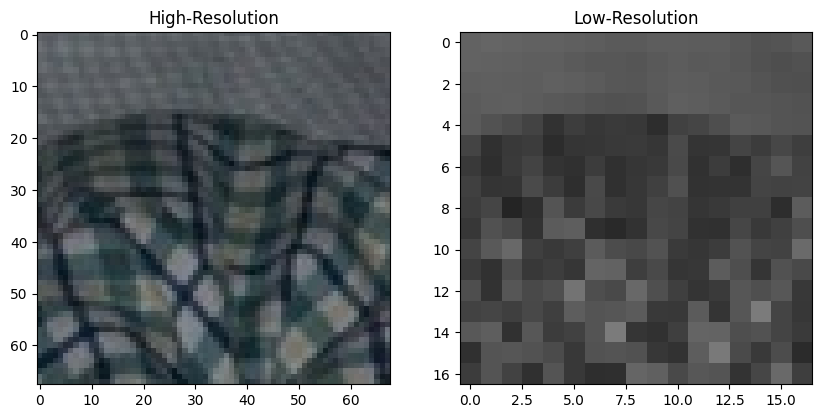

In [ ]:
train_dataset = TrainDataset(train_save_dir, crop_size, upscale_factor)
val_dataset = ValDataset(val_save_dir, crop_size, upscale_factor)

lr, hr = train_dataset[4]
fig, axes = plt.subplots(1, 2, figsize=(10, 10))

print("High-Resolution Shape:", hr.shape)
print("Low-Resolution Shape:", lr.shape)


print("Train Dataset Size:", len(train_dataset))
print("Validation Dataset Size:", len(val_dataset))

axes[0].imshow(hr.permute(1, 2, 0))
axes[0].set_title('High-Resolution')

axes[1].imshow(lr.permute(1, 2, 0))
axes[1].set_title('Low-Resolution')

plt.show()


In [ ]:
train_dataloader = DataLoader(train_dataset, num_workers =2, batch_size = batch_size, shuffle = True)
val_dataloader = DataLoader(val_dataset, num_workers =2, batch_size =1, shuffle=False)

##Model

### Loss Function

In [ ]:
class GeneratorLoss(nn.Module):
    def __init__(self):
        super(GeneratorLoss, self).__init__()
        vgg = vgg16(pretrained=True)
        loss_network = nn.Sequential(*list(vgg.features)[:30]).eval()

        for param in loss_network.parameters():
            param.requires_grad = False

        self.loss_network = loss_network
        self.mse_loss = nn.MSELoss()
        self.tv_loss = TVLoss() #자연스러운 이미지 생성 도와줌.

    def forward(self, out_labels, out_images, target_images):
        # Adversarial Loss
        adversarial_loss = torch.mean(1 - out_labels)
        # Perception Loss
        perception_loss = self.mse_loss(self.loss_network(out_images), self.loss_network(target_images))
        # Image Loss
        image_loss = self.mse_loss(out_images, target_images)
        # TV Loss
        tv_loss = self.tv_loss(out_images)
        return image_loss + 0.001 * adversarial_loss + 0.006 * perception_loss + 2e-8 * tv_loss


class TVLoss(nn.Module):
    def __init__(self, tv_loss_weight=1):
        super(TVLoss, self).__init__()
        self.tv_loss_weight = tv_loss_weight

    def forward(self, x):
        batch_size = x.size()[0]
        h_x = x.size()[2]
        w_x = x.size()[3]
        count_h = self.tensor_size(x[:, :, 1:, :])
        count_w = self.tensor_size(x[:, :, :, 1:])
        h_tv = torch.pow((x[:, :, 1:, :] - x[:, :, :h_x - 1, :]), 2).sum()
        w_tv = torch.pow((x[:, :, :, 1:] - x[:, :, :, :w_x - 1]), 2).sum()
        return self.tv_loss_weight * 2 * (h_tv / count_h + w_tv / count_w) / batch_size

    @staticmethod
    def tensor_size(t):
        return t.size()[1] * t.size()[2] * t.size()[3]


In [ ]:

class Generator(nn.Module):
    def __init__(self, scale_factor):
        upsample_block_num = int(math.log(scale_factor, 2))

        super(Generator, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=9, padding=4),
            nn.PReLU()
        )
        self.block2 = ResidualBlock(64)
        self.block3 = ResidualBlock(64)
        self.block4 = ResidualBlock(64)
        self.block5 = ResidualBlock(64)
        self.block6 = ResidualBlock(64)
        self.block7 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64)
        )
        ##upscaling
        block8 = [UpsampleBLock(64, 2) for _ in range(upsample_block_num)]
        block8.append(nn.Conv2d(64, 3, kernel_size=9, padding=4))
        self.block8 = nn.Sequential(*block8)

        self.colorblock1 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.Softmax(dim=1),
            nn.Conv2d(64, 1, kernel_size=1, padding=0, dilation=1, stride=1, bias=False),
            nn.Upsample(scale_factor=4, mode='bilinear')
        )
        self.colorblock2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.Softmax(dim=1),
            nn.Conv2d(64, 1, kernel_size=1, padding=0, dilation=1, stride=1, bias=False),
            nn.Upsample(scale_factor=4, mode='bilinear')
        )
        self.colorblock3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.Softmax(dim=1),
            nn.Conv2d(64, 1, kernel_size=1, padding=0, dilation=1, stride=1, bias=False),
            nn.Upsample(scale_factor=4, mode='bilinear')
        )

    def forward(self, x):
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)
        block6 = self.block6(block5)
        block7 = self.block7(block6)
        color1 = self.colorblock1(block7)
        color2 = self.colorblock2(block7)
        color3 = self.colorblock3(block7)
        stacked_color = torch.cat([color1, color2,color3], dim=1)
        block8 = self.block8(block7+block1)

        return (stacked_color + torch.tanh(block8) +1)/3

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(512, 1024, kernel_size=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(1024, 1, kernel_size=1)
        )

    def forward(self, x):
        #batch_size = x.size(0)
        return torch.sigmoid(self.net(x))


class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.prelu = nn.PReLU()
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = self.conv1(x)
        residual = self.bn1(residual)
        residual = self.prelu(residual)
        residual = self.conv2(residual)
        residual = self.bn2(residual)

        return x + residual


class UpsampleBLock(nn.Module):
    def __init__(self, in_channels, up_scale):
        super(UpsampleBLock, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels * up_scale ** 2, kernel_size=3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(up_scale)
        self.prelu = nn.PReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.pixel_shuffle(x)
        x = self.prelu(x)
        return x

## GPU 설정

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

netG = Generator(4)
netD = Discriminator()

Generator_loss = GeneratorLoss()

netG.to(device)
netD.to(device)
Generator_loss.to(device)

optimizerG = optim.Adam(netG.parameters())
optimizerD = optim.Adam(netD.parameters())

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 82.8MB/s]


##Training

In [ ]:
print(netG)

Generator(
  (block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): PReLU(num_parameters=1)
  )
  (block2): ResidualBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (prelu): PReLU(num_parameters=1)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block3): ResidualBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (prelu): PReLU(num_parameters=1)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block4): ResidualBlock(
    (conv1)

In [ ]:
checkpoint_D = torch.load("/content/23epochs_d.pt")
#checkpoint_G = torch.load("/content/23epochs_g.pt")
netD.load_state_dict(checkpoint_D)
#netG.load_state_dict(checkpoint_G)

<All keys matched successfully>

In [ ]:
from logging import logProcesses

for epoch in range(0, epochs + 1):
    print("Start {} epochs...".format(epoch))
    train_bar = tqdm(train_dataloader)

    netG.train()
    netD.train()

    for lr_img, hr_img in train_bar:

      lr_img = lr_img.to(device)
      hr_img = hr_img.to(device)

      fake_img = netG(lr_img)

      netD.zero_grad()
      d_loss = netD(hr_img).mean()-1 + netD(fake_img).mean()
      d_loss.backward(retain_graph=True)
      optimizerD.step()

      ############################
      # (2) Update G network: minimize 1-D(G(z)) + Perception Loss + Image Loss + TV Loss
      ###########################
      netG.zero_grad()
      ## The two lines below are added to prevent runetime error in Google Colab ##
      fake_img = netG(lr_img)
      netD_out = netD(fake_img).mean()
      ##
      g_loss = Generator_loss(netD_out, fake_img, hr_img)
      g_loss.backward()

      fake_img = netG(lr_img)
      netD_out = netD(fake_img).mean()

      optimizerG.step()

      #epoch당 val datase 검증
    '''
    netG.eval()
    with torch.no_grad():
        val_bar = tqdm(val_dataloader)
        valing_results = {'mse': 0, 'psnr': 0, 'batch_sizes': 0}
        val_images = []
        for val_lr, val_bicubic, val_hr in val_bar:
            batch_size = val_lr.size(0)
            valing_results['batch_sizes'] += batch_size

            lr = val_lr.to(device)
            hr = val_hr.to(device)
            bicubic = val_bicubic.to(device)

            sr = netG(lr)

            batch_mse = ((sr - hr) ** 2).data.mean()
            valing_results['mse'] += batch_mse * batch_size

        if valing_results['mse'] == 0:
            valing_results['psnr'] = float('inf')
        else:
            psnr = 10 * log10((hr.max()**2) / (valing_results['mse'] / valing_results['batch_sizes']))
            # 만약 psnr 값이 음의 무한대가 될 경우 무한대로 대체
            valing_results['psnr'] = psnr if not math.isinf(psnr) else float('inf')


            print("Val_Score - PSNR: {}".format(valing_results['psnr']))
    '''
    # save model parameters
    torch.save(netG.state_dict(), save_path + '/' + str(epoch) + 'epochs_g')
    torch.save(netD.state_dict(), save_path + '/' + str(epoch) + 'epochs_d')




Start 0 epochs...


100%|██████████| 213/213 [01:55<00:00,  1.85it/s]


Start 1 epochs...


100%|██████████| 213/213 [01:56<00:00,  1.83it/s]


Start 2 epochs...


 79%|███████▉  | 168/213 [01:30<00:23,  1.88it/s]

In [ ]:
from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr
from skimage import data, img_as_float

count = 0
total_g_SSIM = 0
total_b_SSIM = 0
total_r_SSIM = 0
total_SSIM = 0
total_psnr = 0

model = netG.eval()
for f in os.listdir(test_save_dir):
  image = Image.open(test_save_dir+'/'+f)
  ori_image = image.resize((96*4,96*4), Image.BICUBIC)
  image = Grayscale(num_output_channels = 3)( image) #gray
  image = image.resize((96,96), Image.BICUBIC)
  image = ToTensor()(image).unsqueeze(0).to(device)
  sr_img = netG(image)
  sr_image = sr_img.squeeze(0).permute(1, 2, 0).mul(255).clamp(0, 255).detach().cpu().numpy().astype("uint8")
  sr_sr_img = netG(sr_img)
  sr_sr_image = sr_sr_img.squeeze(0).permute(1, 2, 0).mul(255).clamp(0, 255).detach().cpu().numpy().astype("uint8")

  ori_fl = img_as_float(ori_image)
  sr_fl = img_as_float(sr_image)
  (r_score, diff) = ssim(ori_fl[0],sr_fl[0], full=True, channel_axis=1)
  (g_score, diff) = ssim(ori_fl[1],sr_fl[1], full=True,channel_axis=1)
  (b_score, diff) = ssim(ori_fl[2],sr_fl[2], full=True,channel_axis=1)
  (total_score, diff) = ssim(ori_fl,sr_fl, full=True,multichannel=True)
  total_psnr += psnr(ori_fl, sr_fl)

  total_g_SSIM += g_score
  total_r_SSIM += r_score
  total_b_SSIM += b_score
  total_SSIM += total_score
  count+=1
  '''
  # 6. You can print only the score if you want
  print("r_SSIM: {}".format(r_score))
  print("g_SSIM: {}".format(g_score))
  print("b_SSIM: {}".format(b_score))
  print("avg_SSIM: {}".format((total_score)))

  fig, axes = plt.subplots(1, 4, figsize=(10, 5))
  axes[0].imshow(image.squeeze(0).permute(1, 2, 0).clamp(0, 1).cpu().numpy())
  axes[0].set_title('Low-Resolution Input')

  axes[1].imshow(sr_image)
  axes[1].set_title('Generated High-Resolution')

  axes[2].imshow(sr_sr_image)
  axes[2].set_title('One more High-Resolution')

  axes[3].imshow(ori_image)
  axes[3].set_title('Original')
  plt.show()
  '''

print("avg_r_SSIM: {}".format(total_r_SSIM/count))
print("avg_g_SSIM: {}".format(total_g_SSIM/count))
print("avg_b_SSIM: {}".format(total_b_SSIM/count))
print("SSIM: {}".format((total_SSIM/count)))
print("psnr: {}".format((total_psnr/count)))

In [ ]:
import numpy as np
#from imgproc import tensor_to_image


#def tensor_to_image(tensor: Tensor) -> Any:

test_path = '/content/test_dataset'

model = netG.eval()
#image = Image.open(test_path+'/'+'2007_000061.jpg')
image = Image.open('/content/test_dataset/2007_000904.jpg')
image = Grayscale(num_output_channels = 3)( image) #gray
#print(ToTensor()(image).size())
image = image.resize((96,96), Image.BICUBIC)
image = ToTensor()(image).unsqueeze(0).to(device)

sr_img = netG(image)

# 생성된 이미지를 numpy 배열로 변환
sr_image = sr_img.squeeze(0).permute(1, 2, 0).mul(255).clamp(0, 255).detach().cpu().numpy().astype("uint8")
#sr_image = cv2.cvtColor(sr_image, cv2.COLOR_RGB2BGR)

sr_sr_img = netG(sr_img)

print(sr_img)

sr_sr_image = sr_sr_img.squeeze(0).permute(1, 2, 0).mul(255).clamp(0, 255).detach().cpu().numpy().astype("uint8")

fig, axes = plt.subplots(1, 3, figsize=(10, 5))
# 두 번째 subplot에 이미지 표시

axes[0].imshow(image.squeeze(0).permute(1, 2, 0).clamp(0, 1).cpu().numpy())
axes[0].set_title('Low-Resolution Input')

axes[1].imshow(sr_image)
axes[1].set_title('Generated High-Resolution')

axes[2].imshow(sr_sr_image)
axes[2].set_title('One more High-Resolution')
plt.show()

In [ ]:
'''
from torchvision.transforms import ToTensor

# 테스트 이미지 경로
test_dataset_path = '/content/test_dataset'

test_files = [f for f in os.listdir(test_dataset_path) if f.endswith('.jpg')]

# 첫 번째 이미지 파일 경로
first_test_image_path = os.path.join(test_dataset_path, test_files[0])

# 테스트 이미지 불러오기
test_image = Image.open(first_test_image_path).convert('RGB')
# 이미지 전처리 및 모델 입력으로 변환
transform = ToTensor()
input_image = transform(test_image).unsqueeze(0)

# 모델을 CPU 또는 GPU로 이동 (필요에 따라)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
srgan_model = netD.to(device)
input_image = input_image.to(device)

# 모델에 이미지 전달하여 고해상도 이미지 생성
with torch.no_grad():
    output_image = srgan_model(input_image)

# 출력 이미지의 크기 확인
print("Output Image Shape:", output_image.shape)

# 생성된 이미지를 CPU로 이동하고 텐서에서 이미지로 변환
output_image = output_image.cpu().squeeze(0).clamp(0, 1).permute(1, 2, 0).numpy()

# 생성된 이미지 및 원본 이미지 시각화
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(input_image.squeeze(0).permute(1, 2, 0).clamp(0, 1).numpy())
axes[0].set_title('Low-Resolution Input')

axes[1].imshow(output_image)
axes[1].set_title('Generated High-Resolution')

plt.show()
'''
